In [192]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


import pickle
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import scale,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn import metrics

## Data Preprocessing

In [193]:
ex_data = pd.read_csv('data/balanced_dataset.csv')
print(ex_data.head())
ex_data.shape

   subject_id   hadm_id  length_stay insurance marital_status   race  \
0    19989918  20256395    10.000000     Other        MARRIED  WHITE   
1    11366266  23068302    12.765278  Medicare        WIDOWED  WHITE   
2    11681010  20373636     2.250694  Medicaid        MARRIED  ASIAN   
3    14677796  24989222    18.259028     Other        MARRIED  WHITE   
4    11711020  23493168    12.111806     Other         SINGLE  WHITE   

   hospital_expire_flag                                           icd_code  \
0                     0  ['9962', '3453', '34551', '53081', '2724', '27...   
1                     0  ['A419', 'J810', 'I959', 'J439', 'I340', 'K572...   
2                     1  ['0389', '78552', '51881', '5845', '34982', '4...   
3                     1  ['I63411', 'I130', 'I5033', 'N182', 'J9691', '...   
4                     1  ['C9202', 'J9691', 'A4151', 'R6521', 'K7200', ...   

                                         icd_version gender  anchor_age  \
0  [9, 9, 9, 9, 9, 9, 9

(6694, 20)

In [194]:
print(ex_data.hospital_expire_flag.value_counts())
print(ex_data['hospital_expire_flag'])

0    3347
1    3347
Name: hospital_expire_flag, dtype: int64
0       0
1       0
2       1
3       1
4       1
       ..
6689    1
6690    1
6691    1
6692    1
6693    0
Name: hospital_expire_flag, Length: 6694, dtype: int64


In [195]:
# FIND TOP 20 ICD CODES
count = {}
for index, row in ex_data.iterrows():
    for icd_code in eval(row.icd_code):
        
        if icd_code == '0':
            continue
        
        if icd_code not in count:
            count[icd_code] = 1
        else:
            count[icd_code] += 1


In [199]:
sorted_count = dict(sorted(count.items(), key=lambda x: x[1], reverse=True)[:10])
top_20 = list(sorted_count.keys())
sorted_count

{'Z66': 1707,
 'Z515': 1443,
 'E785': 1424,
 'Z87891': 1269,
 'N179': 1260,
 '4019': 1229,
 'I10': 1183,
 'E872': 1067,
 '2724': 1041,
 'V4986': 1041}

In [115]:
count = 0
cols = ex_data.shape[1]
for icd in top_20:
    index = cols + count - 1
    ex_data.insert(index, icd, ex_data.shape[0] * 0)
    count += 1
ex_data.head()

,subject_id,hadm_id,length_stay,insurance,marital_status,race,hospital_expire_flag,icd_code,icd_version,gender,...,I2510,4280,42731,5849,R6521,51881,A419,K219,V1582,num_icd
0,19989918,20256395,10.000000,Other,MARRIED,WHITE,0,"['9962', '3453', '34551', '53081', '2724', '27...","[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, ...",M,...,0,0,0,0,0,0,0,0,0,12.0
1,11366266,23068302,12.765278,Medicare,WIDOWED,WHITE,0,"['A419', 'J810', 'I959', 'J439', 'I340', 'K572...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1...",F,...,0,0,0,0,0,0,0,0,0,15.0
2,11681010,20373636,2.250694,Medicaid,MARRIED,ASIAN,1,"['0389', '78552', '51881', '5845', '34982', '4...","[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ...",M,...,0,0,0,0,0,0,0,0,0,35.0
3,14677796,24989222,18.259028,Other,MARRIED,WHITE,1,"['I63411', 'I130', 'I5033', 'N182', 'J9691', '...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1...",F,...,0,0,0,0,0,0,0,0,0,38.0
4,11711020,23493168,12.111806,Other,SINGLE,WHITE,1,"['C9202', 'J9691', 'A4151', 'R6521', 'K7200', ...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1...",M,...,0,0,0,0,0,0,0,0,0,37.0


In [116]:
for icd in top_20:
    for index, row in ex_data.iterrows():
        if icd in row.icd_code:
            ex_data.at[index, str(icd)] = 1
        else:
            ex_data.at[index, str(icd)] = 0

In [117]:
ex_data.to_csv("balanced_binary_dataset.csv", index=False)

## Load Dataset

In [118]:
ex_data = pd.read_csv("data/balanced_binary_dataset.csv")

In [119]:
# drop unncessary columns from X
ex_X = ex_data.drop(['hospital_expire_flag', 'subject_id', 'hadm_id', 'icd_version', 'icd_code'], axis = 1)
ex_y = np.array(ex_data['hospital_expire_flag'])

# convert categorical data to numerical
ex_X = pd.get_dummies(ex_X, 
                      columns = ['insurance', 'gender', 'marital_status', 'race'], 
                      dtype=int, 
                      drop_first=True)

In [120]:
ex_X

,length_stay,anchor_age,num_procedures,avg_patient_weight,avg_temp,avg_heartrate,avg_resprate,avg_o2sat,avg_sbp,avg_dbp,...,marital_status_WIDOWED,race_ASIAN,race_BLACK/AFRICAN,race_BLACK/AFRICAN AMERICAN,race_BLACK/CAPE VERDEAN,race_BLACK/CARIBBEAN ISLAND,race_HISPANIC/LATINO,race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,race_OTHER,race_WHITE
0,10.000000,50,12,124.4,98.040000,60.200000,16.400000,95.800000,136.600000,72.000000,...,0,0,0,0,0,0,0,0,0,1
1,12.765278,69,15,70.8,98.136667,75.466667,17.133333,98.633333,115.733333,62.500000,...,1,0,0,0,0,0,0,0,0,1
2,2.250694,83,35,55.0,98.118182,88.090909,18.181818,99.000000,108.909091,57.727273,...,0,1,0,0,0,0,0,0,0,0
3,18.259028,83,38,61.0,97.800000,79.000000,17.000000,96.500000,114.500000,80.500000,...,0,0,0,0,0,0,0,0,0,1
4,12.111806,71,37,107.0,98.066667,104.666667,23.333333,89.333333,132.333333,71.000000,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6689,10.468750,56,16,48.8,97.250000,56.500000,14.500000,96.500000,120.500000,74.000000,...,0,0,0,0,0,0,0,0,0,1
6690,8.887500,91,31,50.0,98.160000,69.200000,16.400000,98.000000,116.000000,60.400000,...,1,0,0,0,0,0,0,0,0,1
6691,9.054861,83,39,79.2,98.600000,84.000000,18.800000,99.200000,122.800000,71.800000,...,0,0,0,0,0,0,0,0,0,1
6692,0.714583,91,13,69.1,97.700000,89.000000,22.000000,96.000000,101.000000,63.000000,...,1,0,0,0,0,0,0,0,0,1


In [121]:
def get_performance_scores(y_test, y_predict, y_predict_prob, eps=1e-15, beta=0.5):
    from sklearn import metrics
    # Scores keys.
    metric_keys = ["accuracy", "precision", "recall", "f1", "fbeta", "log_loss", "AUC"]
    # Score values.
    metric_values = [None]*len(metric_keys)
    metric_values[0] = metrics.accuracy_score(y_test, y_predict)
    metric_values[1] = metrics.precision_score(y_test, y_predict)
    metric_values[2] = metrics.recall_score(y_test, y_predict)
    metric_values[3] = metrics.f1_score(y_test, y_predict)
    metric_values[4] = metrics.fbeta_score(y_test, y_predict, beta=beta)
    metric_values[5] = metrics.log_loss(y_test, y_predict_prob[:, 1], eps=eps)
    metric_values[6] = metrics.roc_auc_score(y_test, y_predict_prob[:, 1])
    perf_metrics = dict(zip(metric_keys, metric_values))
    return(perf_metrics)

## KNN

In [122]:
np.random.seed(18)

# test dataset = 30%
X_train, X_test, Y_train, Y_test = train_test_split(ex_X, ex_y, test_size = 0.3)

# using fit_transform and transform to keep the same transformations for the training and
# test data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [123]:
default = 5
kNN = KNeighborsClassifier(n_neighbors = default)

# fit classifier 
kNN.fit(X_train, Y_train)
predictions = kNN.predict(X_test)

In [124]:
conf_matrix_test = metrics.confusion_matrix(Y_test, predictions)
print(conf_matrix_test)

test_accuracy_score = metrics.accuracy_score(Y_test, predictions)
print(test_accuracy_score)

ex_target_names = ex_data['hospital_expire_flag'].unique().tolist()
ex_target_names = [str(x) for x in ex_target_names]

[[863 132]
 [269 745]]
0.8003982080637133


In [125]:
class_report = metrics.classification_report(Y_test, 
                                             predictions, 
                                             target_names = ex_target_names)

print(class_report)

# using prob_a to get probabilities instead of predicted values
prob = kNN.predict_proba(X_test)
print(prob[:10])

# get 2nd column of prob for test probabilities
test_prob = prob[:, 1]
print("prob of mortality:", test_prob[0:10])

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       995
           1       0.85      0.73      0.79      1014

    accuracy                           0.80      2009
   macro avg       0.81      0.80      0.80      2009
weighted avg       0.81      0.80      0.80      2009

[[0.2 0.8]
 [0.6 0.4]
 [0.8 0.2]
 [1.  0. ]
 [1.  0. ]
 [0.8 0.2]
 [1.  0. ]
 [0.  1. ]
 [0.8 0.2]
 [0.4 0.6]]
prob of mortality: [0.8 0.4 0.2 0.  0.  0.2 0.  1.  0.2 0.6]


In [126]:
# print vector of predicted values versus actual values

# use np.column_stack to print side by side
y_hat_vs_y = np.column_stack((Y_test, predictions))
print(y_hat_vs_y[:10])

[[1 1]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [1 1]]


[[863 132]
 [269 745]]


c:\Users\jupit\Anaconda3\envs\AML\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


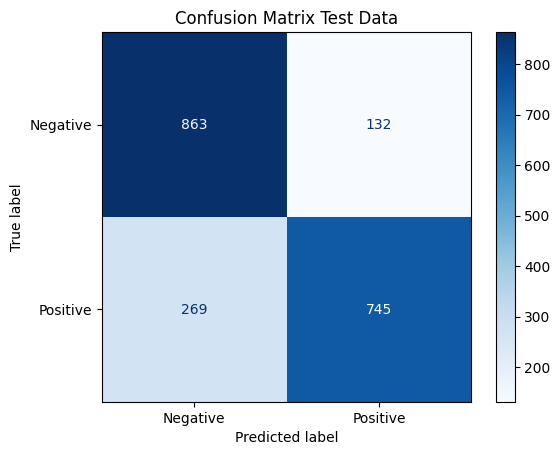

In [127]:
ex_cm_kNN = confusion_matrix(Y_test, predictions)
print(ex_cm_kNN)

# create visualization via matplotlib code from lecture 
plot_confusion_matrix(kNN, X_test, Y_test, cmap=plt.cm.Blues)  
classNames = ['Negative', 'Positive']
plt.title('Confusion Matrix Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))

# set ticks for x and y axis
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames)

plt.show()

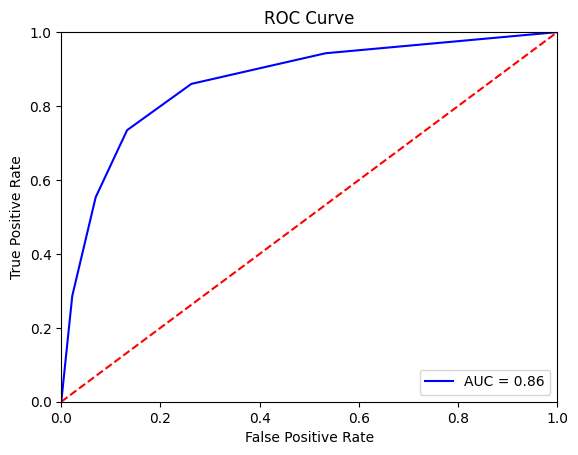

In [128]:
# get fpr, tpr, threshold form .roc_curve with Y_test and predictions as arguments
fpr, tpr, threshold = metrics.roc_curve(Y_test, kNN.predict_proba(X_test)[:,1])
roc_auc = metrics.auc(fpr, tpr)

# roc plotting code from lecture
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [129]:
pipeline = Pipeline([('transformer', StandardScaler()), ('estimator', kNN)])
# get 5 fold cross validation scores
cv_scores = cross_val_score(pipeline, ex_X, ex_y, cv = 10)
print(cv_scores)

mean = np.mean(cv_scores)
mean

[0.80447761 0.7880597  0.77910448 0.80149254 0.78923767 0.76382661
 0.81315396 0.78624813 0.80119581 0.79671151]


0.7923508020435938

In [130]:
# save into dict
knn_scores = get_performance_scores(Y_test, predictions, prob)
results = {"Vanilla KNN":knn_scores}
results

{'Vanilla KNN': {'accuracy': 0.8003982080637133,
  'precision': 0.8494868871151653,
  'recall': 0.7347140039447732,
  'f1': 0.7879428873611846,
  'fbeta': 0.8237505528527199,
  'log_loss': 1.7065391967494796,
  'AUC': 0.8647924038337644}}

## KNN GridSearchCV

In [131]:
k_range = list(range(1, 31))

# use dict to map param names to values that should be searched
param_grid = dict(n_neighbors = k_range)

# run gridsearch with 10 fold cv
grid = GridSearchCV(kNN, param_grid, cv = 10, scoring = 'f1')

In [132]:
grid_search_pipeline = Pipeline([('transformer',  StandardScaler()), ('estimator', grid)])

grid_search_pipeline.fit(ex_X, ex_y)

Pipeline(steps=[('transformer', StandardScaler()),
                ('estimator',
                 GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
                              param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7,
                                                          8, 9, 10, 11, 12, 13,
                                                          14, 15, 16, 17, 18,
                                                          19, 20, 21, 22, 23,
                                                          24, 25, 26, 27, 28,
                                                          29, 30]},
                              scoring='f1'))])

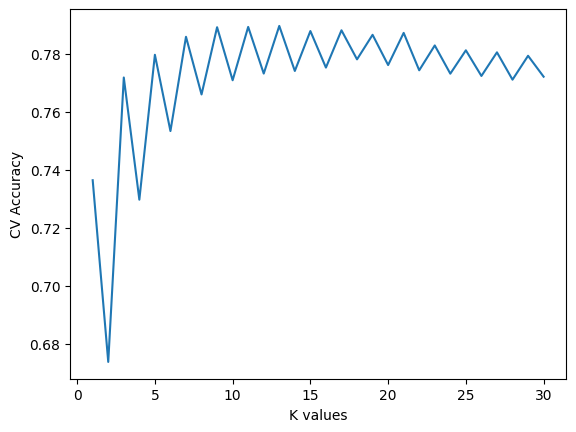

In [133]:
grid_mean_scores = grid.cv_results_['mean_test_score']

# plotting 
plt.plot(k_range, grid_mean_scores)
plt.xlabel('K values')
plt.ylabel('CV Accuracy')
plt.show()

In [134]:
print("F1", grid.best_score_)

print(grid.best_params_)

print(grid.best_estimator_)

F1 0.7896352465003073
{'n_neighbors': 13}
KNeighborsClassifier(n_neighbors=13)


In [135]:
best_kNN = KNeighborsClassifier(n_neighbors = 13)
best_kNN.fit(X_train, Y_train)
predictions = best_kNN.predict(X_test)

In [136]:
conf_matrix_test = metrics.confusion_matrix(Y_test, predictions)
print(conf_matrix_test)

test_accuracy_score = metrics.accuracy_score(Y_test, predictions)
print(test_accuracy_score)

ex_target_names = ex_data['hospital_expire_flag'].unique().tolist()
ex_target_names = [str(x) for x in ex_target_names]


class_report = metrics.classification_report(Y_test, 
                                             predictions, 
                                             target_names = ex_target_names)

print(class_report)

# using prob_a to get probabilities instead of predicted values
prob = kNN.predict_proba(X_test)
print(prob[:10])

# get 2nd column of prob for test probabilities
test_prob = prob[:, 1]
print("Mortality Prob:",test_prob[0:10])

[[884 111]
 [278 736]]
0.8063713290194127
              precision    recall  f1-score   support

           0       0.76      0.89      0.82       995
           1       0.87      0.73      0.79      1014

    accuracy                           0.81      2009
   macro avg       0.81      0.81      0.81      2009
weighted avg       0.82      0.81      0.81      2009

[[0.2 0.8]
 [0.6 0.4]
 [0.8 0.2]
 [1.  0. ]
 [1.  0. ]
 [0.8 0.2]
 [1.  0. ]
 [0.  1. ]
 [0.8 0.2]
 [0.4 0.6]]
Mortality Prob: [0.8 0.4 0.2 0.  0.  0.2 0.  1.  0.2 0.6]


In [137]:
best_knn_scores = get_performance_scores(Y_test, predictions, prob)
results.update({"GridSearchCV KNN":best_knn_scores})
results

{'Vanilla KNN': {'accuracy': 0.8003982080637133,
  'precision': 0.8494868871151653,
  'recall': 0.7347140039447732,
  'f1': 0.7879428873611846,
  'fbeta': 0.8237505528527199,
  'log_loss': 1.7065391967494796,
  'AUC': 0.8647924038337644},
 'GridSearchCV KNN': {'accuracy': 0.8063713290194127,
  'precision': 0.8689492325855962,
  'recall': 0.7258382642998028,
  'f1': 0.7909725953788286,
  'fbeta': 0.8359836437982735,
  'log_loss': 1.7065391967494796,
  'AUC': 0.8647924038337644}}

## Logistic Regression

In [138]:
from sklearn import metrics, preprocessing, linear_model

np.random.seed(18)

# test dataset = 30%
X_train, X_test, Y_train, Y_test = train_test_split(ex_X, ex_y, test_size = 0.3)

scaler = preprocessing.MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg_model = linear_model.LogisticRegression()

log_reg_model.fit(X_train_scaled, Y_train)

predictions = log_reg_model.predict(X_test_scaled)

c:\Users\jupit\Anaconda3\envs\AML\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [139]:
conf_matrix_test = metrics.confusion_matrix(Y_test, predictions)
print(conf_matrix_test)

test_accuracy_score = metrics.accuracy_score(Y_test, predictions)
print(test_accuracy_score)

# get the labels from death_event and convert to list
ex_target_names = ex_data['hospital_expire_flag'].unique().tolist()
ex_target_names = [str(x) for x in ex_target_names]

[[857 138]
 [158 856]]
0.8526630164260827


In [140]:
class_report = metrics.classification_report(Y_test, 
                                             predictions, 
                                             target_names = ex_target_names)

print(class_report)

# using prob_a to get probabilities instead of predicted values
prob = log_reg_model.predict_proba(X_test_scaled)
print(prob[:10])

# get 2nd column of prob for test probabilities
test_prob = prob[:, 1]
print("Mortality prob:",test_prob[0:10])

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       995
           1       0.86      0.84      0.85      1014

    accuracy                           0.85      2009
   macro avg       0.85      0.85      0.85      2009
weighted avg       0.85      0.85      0.85      2009

[[0.0555159  0.9444841 ]
 [0.18835416 0.81164584]
 [0.84455587 0.15544413]
 [0.91697435 0.08302565]
 [0.89110607 0.10889393]
 [0.3947072  0.6052928 ]
 [0.89716908 0.10283092]
 [0.02168528 0.97831472]
 [0.86299244 0.13700756]
 [0.30633543 0.69366457]]
Mortality prob: [0.9444841  0.81164584 0.15544413 0.08302565 0.10889393 0.6052928
 0.10283092 0.97831472 0.13700756 0.69366457]


[[857 138]
 [158 856]]


c:\Users\jupit\Anaconda3\envs\AML\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


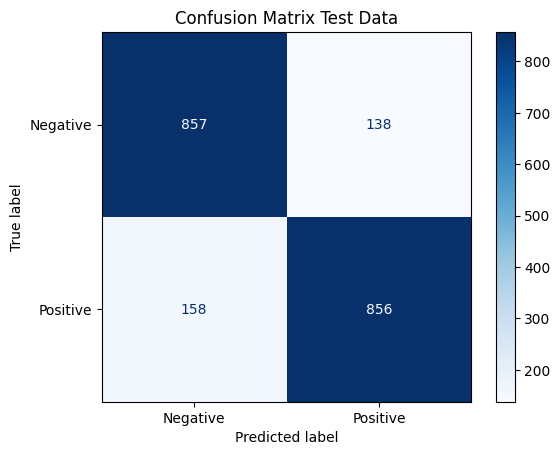

In [141]:
log = confusion_matrix(Y_test, predictions)
print(log)

# create visualization via matplotlib code from lecture 
plot_confusion_matrix(log_reg_model, X_test_scaled, Y_test, cmap=plt.cm.Blues)  
classNames = ['Negative', 'Positive']
plt.title('Confusion Matrix Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))

# set ticks for x and y axis
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames)

plt.show()

False positive:  [0.         0.00100503 0.00100503 0.00201005 0.00201005 0.0040201
 0.0040201  0.00502513 0.00502513 0.00603015]
True positive:  [0.         0.         0.01775148 0.01775148 0.09467456 0.09467456
 0.11538462 0.11538462 0.12524655 0.12524655]
Threshold:  [1.99999361 0.99999361 0.99626842 0.99620992 0.99147106 0.99143245
 0.98968094 0.98943895 0.98836867 0.98830014]
Area under the ROC curve:  0.9172588782175177


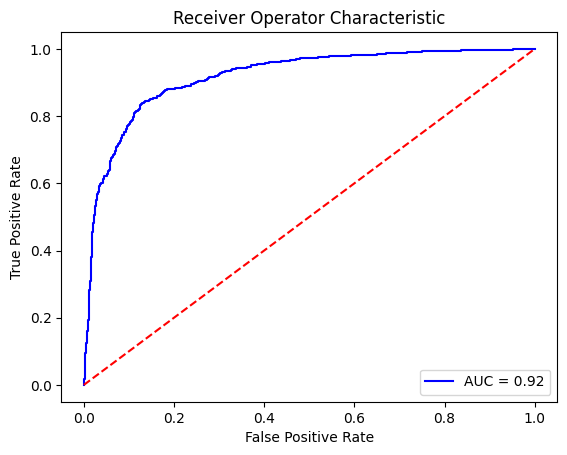

In [142]:
# combining code from lecture
ex_fpr, ex_tpr, ex_threshold = metrics.roc_curve(Y_test, test_prob) 
print("False positive: ", ex_fpr[:10])
print("True positive: ", ex_tpr[:10])
print("Threshold: ", ex_threshold[:10])

# auc score via fpr and tpr arrays.
ex_auc = metrics.auc(ex_fpr, ex_tpr)
print("Area under the ROC curve: ", ex_auc)

# plot roc curve
plt.title('Receiver Operator Characteristic')
plt.plot(ex_fpr, ex_tpr, 'b', label = 'AUC = %0.2f' % ex_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [143]:
log_metrics = get_performance_scores(Y_test, predictions, prob)
results.update({"Vanilla Logistic Reg":log_metrics})
results

{'Vanilla KNN': {'accuracy': 0.8003982080637133,
  'precision': 0.8494868871151653,
  'recall': 0.7347140039447732,
  'f1': 0.7879428873611846,
  'fbeta': 0.8237505528527199,
  'log_loss': 1.7065391967494796,
  'AUC': 0.8647924038337644},
 'GridSearchCV KNN': {'accuracy': 0.8063713290194127,
  'precision': 0.8689492325855962,
  'recall': 0.7258382642998028,
  'f1': 0.7909725953788286,
  'fbeta': 0.8359836437982735,
  'log_loss': 1.7065391967494796,
  'AUC': 0.8647924038337644},
 'Vanilla Logistic Reg': {'accuracy': 0.8526630164260827,
  'precision': 0.8611670020120724,
  'recall': 0.8441814595660749,
  'f1': 0.852589641434263,
  'fbeta': 0.8577154308617235,
  'log_loss': 0.37316599970282904,
  'AUC': 0.9172588782175177}}

## Logistic Regression GridSearchCV 

In [144]:
# l1/lasso and l2/ridge regularization adds pentalty as model complexity increases (more vars)
penalty = ['l1', 'l2']

# create reg constant space
C = np.logspace(0, 10, 10)

# store in dict for CV
hyperparameters = dict(C = C, penalty = penalty)
print(hyperparameters)

{'C': array([1.00000000e+00, 1.29154967e+01, 1.66810054e+02, 2.15443469e+03,
       2.78255940e+04, 3.59381366e+05, 4.64158883e+06, 5.99484250e+07,
       7.74263683e+08, 1.00000000e+10]), 'penalty': ['l1', 'l2']}


In [145]:
# liblinear solver for l1/l2 regularization
clf = GridSearchCV(linear_model.LogisticRegression(solver='liblinear'),
                   hyperparameters,
                   cv = 15)
optimal_model = clf.fit(X_train_scaled, Y_train)
print(optimal_model)

GridSearchCV(cv=15, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': array([1.00000000e+00, 1.29154967e+01, 1.66810054e+02, 2.15443469e+03,
       2.78255940e+04, 3.59381366e+05, 4.64158883e+06, 5.99484250e+07,
       7.74263683e+08, 1.00000000e+10]),
                         'penalty': ['l1', 'l2']})


In [146]:
penalty = optimal_model.best_estimator_.get_params()['penalty']
constant = optimal_model.best_estimator_.get_params()['C']
print('Best penalty: ', penalty)
print('Best C: ', constant)

Best penalty:  l1
Best C:  1.0


In [147]:
best_predictions = optimal_model.predict(X_test_scaled)

# Optimal Accuracy Score for training dataset
train_best_accuracy_score = optimal_model.score(X_train_scaled, Y_train)
print("Accuracy on train data: " , train_best_accuracy_score)

# Optimal Accuracy Score for testing dataset
test_best_accuracy_score = metrics.accuracy_score(Y_test, best_predictions)
print("Accuracy on test data (best model): ", test_best_accuracy_score)


best_confusion_matrix = metrics.confusion_matrix(Y_test, best_predictions)
print(best_confusion_matrix)

best_probabilities = optimal_model.predict_proba(X_test_scaled)

# get the labels from death_event and convert to list
ex_target_names = ex_data['hospital_expire_flag'].unique().tolist()
ex_target_names = [str(x) for x in ex_target_names]

ex_best_class_report = metrics.classification_report(Y_test, best_predictions, target_names = ex_target_names)
print(ex_best_class_report)

Accuracy on train data:  0.8518676627534685
Accuracy on test data (best model):  0.8541562966650075
[[858 137]
 [156 858]]
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       995
           1       0.86      0.85      0.85      1014

    accuracy                           0.85      2009
   macro avg       0.85      0.85      0.85      2009
weighted avg       0.85      0.85      0.85      2009



In [148]:
best_log = get_performance_scores(Y_test, best_predictions, best_probabilities)

0.9185196197952286


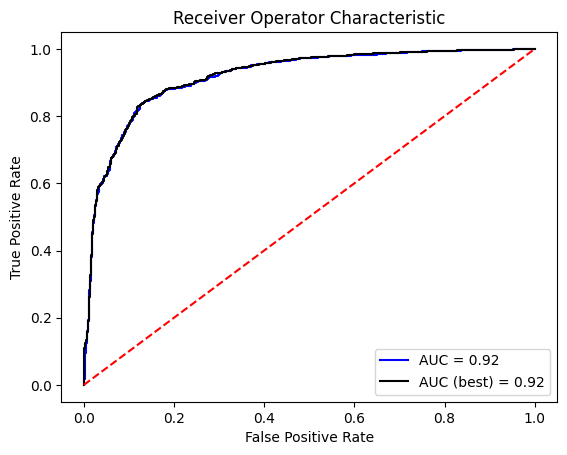

In [149]:
best_probabilities = optimal_model.predict_proba(X_test_scaled)

# test probs are in second column
test_best_probs = best_probabilities[: ,1]

# get ROC values: fpr, tpr, threshold
ex_best_fpr, ex_best_tpr, ex_best_threshold = metrics.roc_curve(Y_test, test_best_probs)

# calculate AUC area
ex_best_auc = metrics.auc(ex_best_fpr, ex_best_tpr)
print(ex_best_auc)

# plot ROC curve with best and previous models, code from lecture
plt.title('Receiver Operator Characteristic')
plt.plot(ex_fpr, ex_tpr, 'b', label = 'AUC = %0.2f' % ex_auc)
plt.plot(ex_best_fpr, ex_best_tpr, 'black', label = 'AUC (best) = %0.2f' % ex_best_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

[[858 137]
 [156 858]]


c:\Users\jupit\Anaconda3\envs\AML\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


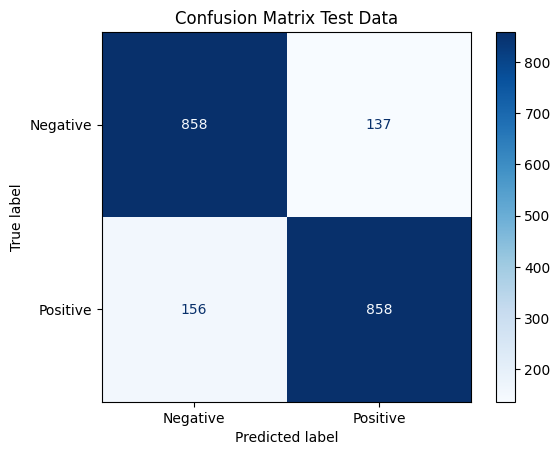

In [150]:
log = confusion_matrix(Y_test, best_predictions)
print(log)

# create visualization via matplotlib code from lecture 
plot_confusion_matrix(optimal_model, X_test_scaled, Y_test, cmap=plt.cm.Blues)  
classNames = ['Negative', 'Positive']
plt.title('Confusion Matrix Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))

# set ticks for x and y axis
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames)

plt.show()

In [151]:
results.update({'GridSearchCV Logistic Regression': get_performance_scores(Y_test, best_predictions, best_probabilities)})
results

{'Vanilla KNN': {'accuracy': 0.8003982080637133,
  'precision': 0.8494868871151653,
  'recall': 0.7347140039447732,
  'f1': 0.7879428873611846,
  'fbeta': 0.8237505528527199,
  'log_loss': 1.7065391967494796,
  'AUC': 0.8647924038337644},
 'GridSearchCV KNN': {'accuracy': 0.8063713290194127,
  'precision': 0.8689492325855962,
  'recall': 0.7258382642998028,
  'f1': 0.7909725953788286,
  'fbeta': 0.8359836437982735,
  'log_loss': 1.7065391967494796,
  'AUC': 0.8647924038337644},
 'Vanilla Logistic Reg': {'accuracy': 0.8526630164260827,
  'precision': 0.8611670020120724,
  'recall': 0.8441814595660749,
  'f1': 0.852589641434263,
  'fbeta': 0.8577154308617235,
  'log_loss': 0.37316599970282904,
  'AUC': 0.9172588782175177},
 'GridSearchCV Logistic Regression': {'accuracy': 0.8541562966650075,
  'precision': 0.8623115577889447,
  'recall': 0.8461538461538461,
  'f1': 0.8541562966650074,
  'fbeta': 0.8590308370044053,
  'log_loss': 0.3676927050917961,
  'AUC': 0.9185196197952286}}

## Decision Trees

In [152]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


import pickle
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import scale,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn import metrics, preprocessing, linear_model
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from matplotlib.legend_handler import HandlerLine2D

In [153]:
X_train, X_test, Y_train, Y_test = train_test_split(ex_X, ex_y, test_size = 0.3)
clf = tree.DecisionTreeClassifier()
clf_fit = clf.fit(X_train, Y_train)

predictions = clf_fit.predict(X_test)

In [154]:
conf_matrix_test = metrics.confusion_matrix(Y_test, predictions)
print(conf_matrix_test)

test_accuracy_score = metrics.accuracy_score(Y_test, predictions)
print(test_accuracy_score)

ex_target_names = ex_data['hospital_expire_flag'].unique().tolist()
ex_target_names = [str(x) for x in ex_target_names]


class_report = metrics.classification_report(Y_test, 
                                             predictions, 
                                             target_names = ex_target_names)

print(class_report)

# using prob_a to get probabilities instead of predicted values
prob = clf_fit.predict_proba(X_test)
print(prob[:10])

# get 2nd column of prob for test probabilities
test_prob = prob[:, 1]
print("Mortality Prob",test_prob[0:10])

[[824 206]
 [196 783]]
0.7999004479840717
              precision    recall  f1-score   support

           0       0.81      0.80      0.80      1030
           1       0.79      0.80      0.80       979

    accuracy                           0.80      2009
   macro avg       0.80      0.80      0.80      2009
weighted avg       0.80      0.80      0.80      2009

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]
Mortality Prob [1. 0. 0. 0. 0. 1. 0. 0. 1. 0.]


In [155]:
cv_scores = cross_val_score(clf, ex_X, ex_y, cv = 10)
print("CV acc score:", cv_scores.mean())

CV acc score: 0.7896602190839526


In [156]:
rf_metrics = get_performance_scores(Y_test, predictions, prob)
results.update({"DT": rf_metrics})
results

{'Vanilla KNN': {'accuracy': 0.8003982080637133,
  'precision': 0.8494868871151653,
  'recall': 0.7347140039447732,
  'f1': 0.7879428873611846,
  'fbeta': 0.8237505528527199,
  'log_loss': 1.7065391967494796,
  'AUC': 0.8647924038337644},
 'GridSearchCV KNN': {'accuracy': 0.8063713290194127,
  'precision': 0.8689492325855962,
  'recall': 0.7258382642998028,
  'f1': 0.7909725953788286,
  'fbeta': 0.8359836437982735,
  'log_loss': 1.7065391967494796,
  'AUC': 0.8647924038337644},
 'Vanilla Logistic Reg': {'accuracy': 0.8526630164260827,
  'precision': 0.8611670020120724,
  'recall': 0.8441814595660749,
  'f1': 0.852589641434263,
  'fbeta': 0.8577154308617235,
  'log_loss': 0.37316599970282904,
  'AUC': 0.9172588782175177},
 'GridSearchCV Logistic Regression': {'accuracy': 0.8541562966650075,
  'precision': 0.8623115577889447,
  'recall': 0.8461538461538461,
  'f1': 0.8541562966650074,
  'fbeta': 0.8590308370044053,
  'log_loss': 0.3676927050917961,
  'AUC': 0.9185196197952286},
 'DT': {'

## Optimized Decision Tree

In [157]:
# function from lecture
def optimal_parameter(values,test_results):
    best_test_value = max(test_results)
    best_test_index = test_results.index(best_test_value)
    best_value = values[best_test_index]
    return best_value 

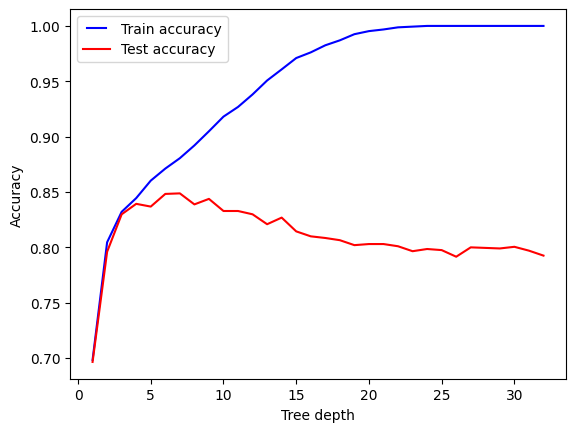

In [158]:
# create depths from 1-32 for decision tree with linspace; increasing max_depth captures more info- care for overfitting
ex_max_depths = np.linspace(1, 32, 32, endpoint = True)
# arrays to store training/testing results
ex_train_results = []
ex_test_results = []

# iterate through depths
for max_depth in ex_max_depths:
    
    # create DT with curr max_depth
    ex_dt = DecisionTreeClassifier(max_depth = int(max_depth))
    ex_dt.fit(X_train, Y_train)
   
    # predict on the DT and get accuracy score for train
    ex_train_pred = ex_dt.predict(X_train)
    ex_acc_train = accuracy_score(Y_train, ex_train_pred)
    ex_train_results.append(ex_acc_train)
   
    # predict the test data set and get testing acc
    ex_y_pred = ex_dt.predict(X_test)
    ex_acc_test = accuracy_score(Y_test, ex_y_pred)
    ex_test_results.append(ex_acc_test)

optimal_max_depth = optimal_parameter(ex_max_depths, ex_test_results)

# plotting code from lecture to visualize tree_depth vs accuracies 
# Plot max depth over 1 - 32. 
line1, = plt.plot(ex_max_depths, ex_train_results, 'b', label= "Train accuracy")
line2, = plt.plot(ex_max_depths, ex_test_results, 'r', label= "Test accuracy")

plt.legend(handler_map={line1: HandlerLine2D(numpoints = 2)})
plt.ylabel('Accuracy')
plt.xlabel('Tree depth')
plt.show()

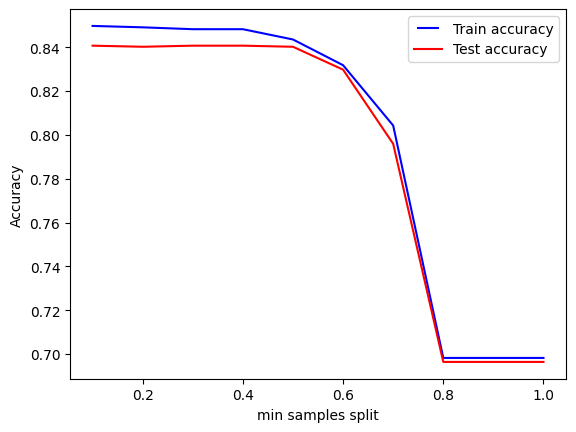

In [159]:
# linspace from 10% to 100%; tree becomes more constrained when min_samples_split increases
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
ex_train_results = []
ex_test_results = []


# follows same logic as max_depth code above but specialized for min_samples_split
for min_samples_split in min_samples_splits:
    
    # create DT with curr min_samples_splits
    ex_dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
    ex_dt.fit(X_train, Y_train)
   
    # predict on the DT and get accuracy score for train
    ex_train_pred = ex_dt.predict(X_train)
    ex_acc_train = accuracy_score(Y_train, ex_train_pred)
    ex_train_results.append(ex_acc_train)
   
    # predict the test data set and get testing acc
    ex_y_pred = ex_dt.predict(X_test)
    ex_acc_test = accuracy_score(Y_test, ex_y_pred)
    ex_test_results.append(ex_acc_test)
    
optimal_min_samples_split = optimal_parameter(min_samples_splits,ex_test_results) 

# Plot min_sample split.
line1, = plt.plot(min_samples_splits, ex_train_results, 'b', label = "Train accuracy")
line2, = plt.plot(min_samples_splits, ex_test_results, 'r', label = "Test accuracy")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy')
plt.xlabel('min samples split')
plt.show()

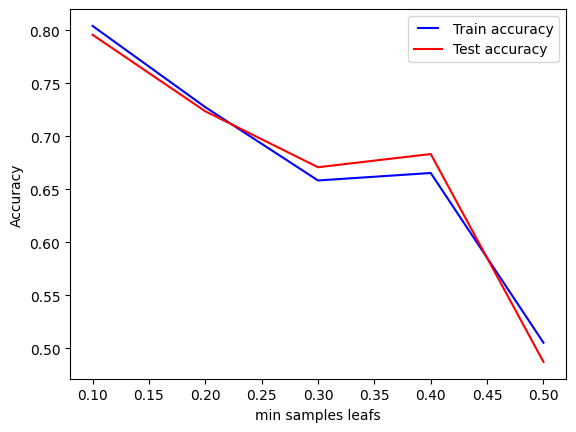

In [160]:
# code from lecture: linespace from 10% to 50%
ex_min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint = True)
ex_train_results = []
ex_test_results = []

for min_samples_leaf in ex_min_samples_leafs:
   # create DT with curr min_samples_leafs
    ex_dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    ex_dt.fit(X_train, Y_train)
   
    # predict on the DT and get accuracy score for train
    ex_train_pred = ex_dt.predict(X_train)
    ex_acc_train = accuracy_score(Y_train, ex_train_pred)
    ex_train_results.append(ex_acc_train)
   
    # predict the test data set and get testing acc
    ex_y_pred = ex_dt.predict(X_test)
    ex_acc_test = accuracy_score(Y_test, ex_y_pred)
    ex_test_results.append(ex_acc_test)

ex_optimal_min_samples_leafs = optimal_parameter(ex_min_samples_leafs, ex_test_results)

line1, = plt.plot(ex_min_samples_leafs, ex_train_results, 'b', label= "Train accuracy")
line2, = plt.plot(ex_min_samples_leafs, ex_test_results, 'r', label= "Test accuracy")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy')
plt.xlabel('min samples leafs')
plt.show()

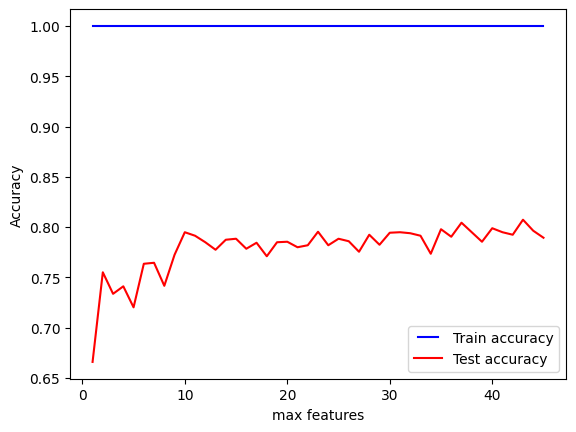

In [161]:
# code from lecture
# get num of columns in ex_X for max range value
ex_max_features = list(range(1, ex_X.shape[1]))
ex_train_results = []
ex_test_results = []

for max_feature in ex_max_features:
   # create DT with curr min_samples_leafs
    ex_dt = DecisionTreeClassifier(max_features=max_feature)
    ex_dt.fit(X_train, Y_train)
   
    # predict on the DT and get accuracy score for train
    ex_train_pred = ex_dt.predict(X_train)
    ex_acc_train = accuracy_score(Y_train, ex_train_pred)
    ex_train_results.append(ex_acc_train)
   
    # predict the test data set and get testing acc
    ex_y_pred = ex_dt.predict(X_test)
    ex_acc_test = accuracy_score(Y_test, ex_y_pred)
    ex_test_results.append(ex_acc_test)

ex_optimal_max_features = optimal_parameter(ex_max_features, ex_test_results)

line1, = plt.plot(ex_max_features, ex_train_results, 'b', label= "Train accuracy")
line2, = plt.plot(ex_max_features, ex_test_results, 'r', label= "Test accuracy")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy')
plt.xlabel('max features')
plt.show()

In [162]:
print("optimal max depth:", optimal_max_depth)
print("optimal min samples split:", optimal_min_samples_split)
print("optimal min samples leaf:", ex_optimal_min_samples_leafs)
print("optimal max features:", ex_optimal_max_features)

optimal max depth: 7.0
optimal min samples split: 0.1
optimal min samples leaf: 0.1
optimal max features: 43


In [163]:
optimized_clf = tree.DecisionTreeClassifier(max_depth = int(optimal_max_depth),
                                            min_samples_split = optimal_min_samples_split,
                                            min_samples_leaf = ex_optimal_min_samples_leafs,
                                            max_features = ex_optimal_max_features)

clf_optimized_fit = optimized_clf.fit(X_train, Y_train)
y_predict_optimized = clf_optimized_fit.predict(X_test)

ex_acc_score_tree_optimized = accuracy_score(Y_test, y_predict_optimized)
print(ex_acc_score_tree_optimized)

0.7959183673469388


In [164]:
ex_target_names = ex_data['hospital_expire_flag'].unique().tolist()
ex_target_names = [str(x) for x in ex_target_names]
class_report = metrics.classification_report(Y_test, 
                                             y_predict_optimized, 
                                             target_names = ex_target_names)
print(class_report)
y_prob_optimized = clf_optimized_fit.predict_proba(X_test)


              precision    recall  f1-score   support

           0       0.74      0.93      0.82      1030
           1       0.90      0.65      0.76       979

    accuracy                           0.80      2009
   macro avg       0.82      0.79      0.79      2009
weighted avg       0.82      0.80      0.79      2009



In [165]:
best_rf_metrics = get_performance_scores(Y_test, y_predict_optimized,y_prob_optimized)
results.update({"Optimized DT":best_rf_metrics})
results

{'Vanilla KNN': {'accuracy': 0.8003982080637133,
  'precision': 0.8494868871151653,
  'recall': 0.7347140039447732,
  'f1': 0.7879428873611846,
  'fbeta': 0.8237505528527199,
  'log_loss': 1.7065391967494796,
  'AUC': 0.8647924038337644},
 'GridSearchCV KNN': {'accuracy': 0.8063713290194127,
  'precision': 0.8689492325855962,
  'recall': 0.7258382642998028,
  'f1': 0.7909725953788286,
  'fbeta': 0.8359836437982735,
  'log_loss': 1.7065391967494796,
  'AUC': 0.8647924038337644},
 'Vanilla Logistic Reg': {'accuracy': 0.8526630164260827,
  'precision': 0.8611670020120724,
  'recall': 0.8441814595660749,
  'f1': 0.852589641434263,
  'fbeta': 0.8577154308617235,
  'log_loss': 0.37316599970282904,
  'AUC': 0.9172588782175177},
 'GridSearchCV Logistic Regression': {'accuracy': 0.8541562966650075,
  'precision': 0.8623115577889447,
  'recall': 0.8461538461538461,
  'f1': 0.8541562966650074,
  'fbeta': 0.8590308370044053,
  'log_loss': 0.3676927050917961,
  'AUC': 0.9185196197952286},
 'DT': {'

## Gradient Boosting

In [166]:
# imports from lecture
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from textwrap import wrap
import pickle
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import scale,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn import metrics, preprocessing, linear_model

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

np.random.seed(24)
# test dataset = 30%
X_train, X_test, y_train, y_test = train_test_split(ex_X, ex_y, test_size = 0.3)

In [167]:
# declaring gbm with default values
gbm_ex = GradientBoostingClassifier(n_estimators = 100, 
                                    learning_rate = 1, 
                                    max_depth = 1,  
                                    random_state = 1)


gbm_ex.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=1, max_depth=1, random_state=1)

In [168]:
predictions = gbm_ex.predict(X_test)

ex_target_names = ex_data['hospital_expire_flag'].unique().tolist()
ex_target_names = [str(x) for x in ex_target_names]
class_report = metrics.classification_report(y_test, 
                                             predictions, 
                                             target_names = ex_target_names)
print(class_report)

conf_matrix_gbm_ex = metrics.confusion_matrix(y_test, predictions)
print(conf_matrix_gbm_ex)

accuracy_gbm_ex = metrics.accuracy_score(y_test, predictions)
print("Test Accuracy: ", accuracy_gbm_ex)

prob = gbm_ex.predict_proba(X_test)

              precision    recall  f1-score   support

           0       0.86      0.87      0.86      1024
           1       0.86      0.85      0.85       985

    accuracy                           0.86      2009
   macro avg       0.86      0.86      0.86      2009
weighted avg       0.86      0.86      0.86      2009

[[887 137]
 [148 837]]
Test Accuracy:  0.8581383773021404


In [169]:
results.update({"Gradient Boosting": get_performance_scores(y_test, predictions, prob)})
results

{'Vanilla KNN': {'accuracy': 0.8003982080637133,
  'precision': 0.8494868871151653,
  'recall': 0.7347140039447732,
  'f1': 0.7879428873611846,
  'fbeta': 0.8237505528527199,
  'log_loss': 1.7065391967494796,
  'AUC': 0.8647924038337644},
 'GridSearchCV KNN': {'accuracy': 0.8063713290194127,
  'precision': 0.8689492325855962,
  'recall': 0.7258382642998028,
  'f1': 0.7909725953788286,
  'fbeta': 0.8359836437982735,
  'log_loss': 1.7065391967494796,
  'AUC': 0.8647924038337644},
 'Vanilla Logistic Reg': {'accuracy': 0.8526630164260827,
  'precision': 0.8611670020120724,
  'recall': 0.8441814595660749,
  'f1': 0.852589641434263,
  'fbeta': 0.8577154308617235,
  'log_loss': 0.37316599970282904,
  'AUC': 0.9172588782175177},
 'GridSearchCV Logistic Regression': {'accuracy': 0.8541562966650075,
  'precision': 0.8623115577889447,
  'recall': 0.8461538461538461,
  'f1': 0.8541562966650074,
  'fbeta': 0.8590308370044053,
  'log_loss': 0.3676927050917961,
  'AUC': 0.9185196197952286},
 'DT': {'

Text(0.5, 0, 'Relative Importance')

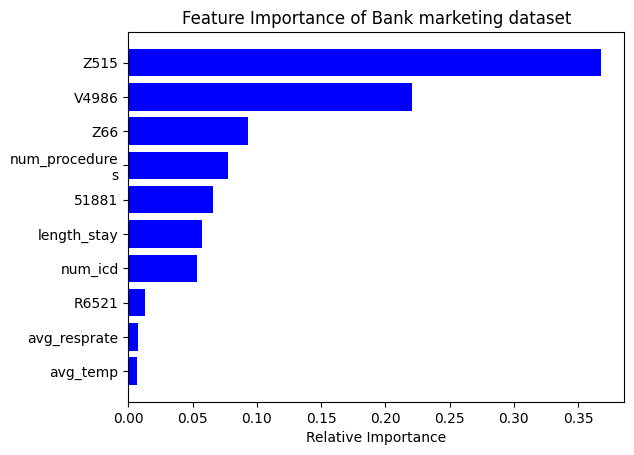

In [170]:
features_ex = ex_X.columns
importances_ex = gbm_ex.feature_importances_
indices_ex = np.argsort(importances_ex)[::-1]
top_indices_ex = indices_ex[0:10][::-1]

plt.figure(1)
plt.title('Feature Importance of Bank marketing dataset')
plt.barh(range(len(top_indices_ex)), importances_ex[top_indices_ex], color = 'b', align = 'center')
labels = features_ex[top_indices_ex]
labels = [ '\n'.join(wrap(l,13)) for l in labels ]
plt.yticks(range(len(top_indices_ex)), labels)
plt.xlabel('Relative Importance')

## Optimizing Gradient

In [178]:
# imports from lecture
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import math
from textwrap import wrap
import pickle
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import scale,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import pickle
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn import metrics, preprocessing, linear_model

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

gbm_ex = GradientBoostingClassifier()

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 20)]

max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

min_samples_split = [2, 5, 10]

min_samples_leaf = [1, 2, 4]
learning_rate = [0.001, 0.01, 0.1, 0.2, 0.3]

random_grid_ex = {'n_estimators': n_estimators,
                  'max_features': max_features,
                  'max_depth': max_depth,
                  'min_samples_split': min_samples_split,
                  'min_samples_leaf': min_samples_leaf,
                  'learning_rate': learning_rate}  

In [179]:
gbm_random_ex = RandomizedSearchCV(estimator = gbm_ex, 
                                   param_distributions = random_grid_ex, 
                                   n_iter = 100, 
                                   cv = 3, 
                                   verbose = 0, 
                                   random_state = 1, 
                                   n_jobs = -1)
                                   
gbm_random_ex.fit(X_train, Y_train)
gbm_random_ex.best_params_

{'n_estimators': 1052,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 70,
 'learning_rate': 0.1}

## SVM

In [181]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [183]:
X_train_ex, X_test_ex, y_train_ex, y_test_ex = train_test_split(ex_X, ex_y, test_size = 0.3)

In [184]:
ex_sv_machine = SVC(kernel = 'rbf', gamma = 0.011, probability = True)
ex_sv_machine.fit(X_train_ex, y_train_ex)

SVC(gamma=0.011, probability=True)

In [185]:
ex_svm_y_predict = ex_sv_machine.predict(X_test_ex)
print(ex_svm_y_predict[:5])

ex_svm_y_predict_prob = ex_sv_machine.predict_proba(X_test_ex) 
print(ex_svm_y_predict_prob[5:])

[0 1 0 1 1]
[[0.88074017 0.11925983]
 [0.48981663 0.51018337]
 [0.13620232 0.86379768]
 ...
 [0.63160862 0.36839138]
 [0.73224358 0.26775642]
 [0.37561227 0.62438773]]


In [186]:
ex_svm_scores = get_performance_scores(y_test_ex, ex_svm_y_predict, ex_svm_y_predict_prob)
print(ex_svm_scores)

{'accuracy': 0.6769537083125934, 'precision': 0.6432, 'recall': 0.7984111221449851, 'f1': 0.7124501550731057, 'fbeta': 0.6692192442150824, 'log_loss': 0.6140760456640786, 'AUC': 0.7320795350708712}


In [187]:
ex_tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]}]

ex_svm_cv = GridSearchCV(SVC(), ex_tuned_parameters, cv = 5)
ex_svm_cv.fit(X_train_ex, y_train_ex)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}])

In [188]:
print(ex_svm_cv.best_params_)
ex_optmized_c = ex_svm_cv.best_params_['C']
ex_optmized_gamma = ex_svm_cv.best_params_['gamma']
ex_optmized_kernel = ex_svm_cv.best_params_['kernel']

{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}


In [189]:
# running model with best model param values
ex_sv_cv_optimized = SVC(kernel = ex_optmized_kernel,
                        gamma = ex_optmized_gamma, 
                        C = ex_optmized_c,
                        probability = True)
ex_sv_cv_optimized.fit(X_train_ex, y_train_ex)

SVC(C=100, gamma=0.0001, probability=True)

In [ ]:
# same logic as before to print labels and probability predictions
ex_opt_svm_y_predict = ex_sv_cv_optimized.predict(X_test_ex)
print(ex_opt_svm_y_predict[:5])

ex_opt_svm_y_predict_prob = ex_sv_cv_optimized.predict_proba(X_test_ex) 
print(ex_opt_svm_y_predict_prob[5:])

In [190]:
ex_opt_svm_scores = get_performance_scores(y_test_ex, ex_opt_svm_y_predict, ex_opt_svm_y_predict_prob)
print(ex_opt_svm_scores)

NameError: name 'ex_opt_svm_y_predict' is not defined